In [11]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [12]:
import pandas as pd

In [13]:
pd.options.display.max_columns=500
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

In [14]:
import matplotlib.pyplot as plt

In [222]:
def show_rgb_image(tensor_state):
    plt.imshow(tensor_state.cpu().detach().numpy().transpose(1, 2, 0))
    
def show_bw_image(tensor_state):
    plt.imshow(tensor_state.cpu().detach().numpy())
    
    
def kernel_show(length, kernel_list, row=5):
    fig, axes = plt.subplots(int(length / row) + 1, row, figsize=(15,10))
    axes = axes.flatten()
    for i in range(length):
        axes[i].imshow(kernel_list[i].cpu().detach())
        
def list_show(l, st, end):
    fig, axes = plt.subplots(1, end - st + 1, figsize=(15,10))
    axes = axes.flatten()
    for i in range(end - st + 1):
        axes[i].imshow(l[i].cpu().detach().numpy().transpose(1, 2, 0))

In [303]:
class Environment(gym.Wrapper):
    move = -1
    eat_cookie = 100
    eat_ghost = 0
    death = -1000

    def __init__(self):
        super(Environment, self).__init__(gym.make('MsPacman-v0'))

        self._move_reward = Environment.move
        self._eat_cookie_reward = Environment.eat_cookie
        self._death_reward = Environment.death
        self._eat_ghost_reward = Environment.eat_ghost

    def reset(self,
              move_reward: int = move,
              eat_cookie_reward: int = eat_cookie,
              death_reward: int = death,
              eat_ghost_reward: int = eat_ghost,
              **kwargs):

        self._move_reward = move_reward
        self._eat_cookie_reward = eat_cookie_reward
        self._death_reward = death_reward
        self._eat_ghost_reward = eat_ghost_reward

        self._metadata = {
            'lives': 3,
            'get_coin': 0
        }

        state = super(Environment, self).reset(**kwargs)
        return self.observation(state)

    def step(self, action):

        state_prime, reward, done, info = super(Environment, self).step(action)

        state_prime = self.observation(state_prime)
        new_reward = self.reward(reward, info)

        self._metadata['lives'] = info['lives']
                
        return state_prime, new_reward, done, info

    def reward(self, reward, info):

        new_reward = 0

        # move
        if reward == 0:
            new_reward = self._move_reward
        # eat
        elif reward == 10:
            new_reward = self._eat_cookie_reward
            self._metadata['get_coin'] += 1
        elif reward == 200:
            new_reward = self._eat_ghost_reward

        if self._metadata['lives'] > info['lives'] != 3:
            new_reward += self._death_reward * (1 - (self._metadata['get_coin'] % 150) / 150)
            self._metadata['get_coin'] = 0 # 한 목숨당 처리하도록? 처음에 많이 먹고 나중에 ㅈㄴ 놀수 있으니깐..?

        return new_reward

    def observation(self, observation):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((110, 84)),
            transforms.ToTensor()
        ])
        

        return transform(observation)[:84, :84]



In [304]:
import gym

env = Environment()

state = env.reset()

result = []

for _ in range(10000):
    state_prime, reward, done, info = env.step(env.action_space.sample())
    
    result.append({
        'state': state,
        'state_prime': state_prime,
        'reward': reward,
        'done': done,
        'info': info
    })
    
    if done:
        break
    
    state = state_prime


In [305]:
len(result)

636

In [306]:
test_state = result[450]['state']

In [310]:
test_state.shape

torch.Size([1, 84, 84])

In [311]:
test_state[0]

tensor([[0.3098, 0.3059, 0.2706,  ..., 0.2706, 0.3059, 0.3098],
        [0.5725, 0.5451, 0.2588,  ..., 0.2588, 0.5451, 0.5725],
        [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
        ...,
        [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
        [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
        [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725]])

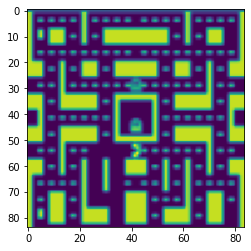

In [313]:
show_rgb_image(test_state)

In [274]:
test_state = torch.cat([result[450]['state'], result[451]['state'], result[452]['state']])

In [275]:
rgb_state = test_state.unsqueeze(0)

In [276]:
rgb_state.shape

torch.Size([1, 3, 84, 84])

In [277]:
rgb_state[0]

tensor([[[0.3098, 0.3059, 0.2706,  ..., 0.2706, 0.3059, 0.3098],
         [0.5725, 0.5451, 0.2588,  ..., 0.2588, 0.5451, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         ...,
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725]],

        [[0.3098, 0.3059, 0.2706,  ..., 0.2706, 0.3059, 0.3098],
         [0.5725, 0.5451, 0.2588,  ..., 0.2588, 0.5451, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         ...,
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.5725]],

        [[0.3098, 0.3059, 0.2706,  ..., 0.2706, 0.3059, 0.3098],
         [0.5725, 0.5451, 0.2588,  ..., 0.2588, 0.5451, 0.5725],
         [0.5725, 0.5412, 0.2039,  ..., 0.2039, 0.5412, 0.

### Layer1

In [278]:
test_layer1 = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=16,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(16, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)

In [279]:
layer1_result = test_layer1(rgb_state)
layer1_result.shape

torch.Size([1, 16, 41, 41])

In [280]:
len(layer1_result.view(-1))

26896

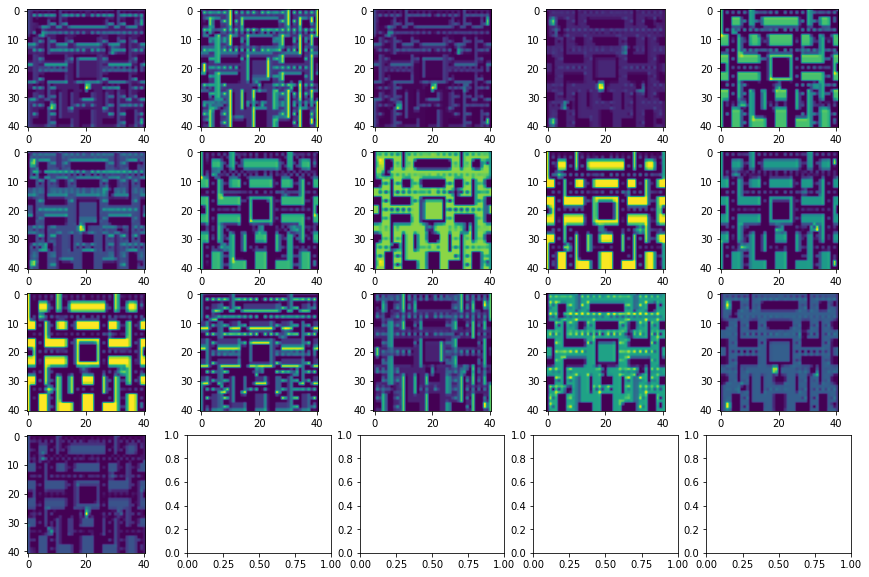

In [281]:
kernel_show(kernel_list=layer1_result[0], length=len(layer1_result[0]), row=5)

### Layer2

In [286]:
test_layer2 = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=16,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(16, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16,
        out_channels=32,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(32, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
)

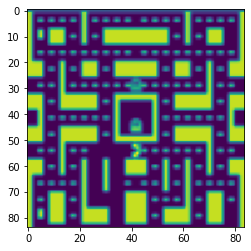

In [314]:
show_rgb_image(test_state)

In [315]:
layer2_result = test_layer2(rgb_state)
layer2_result.shape

torch.Size([1, 32, 20, 20])

In [316]:
len(layer2_result.view(-1))

12800

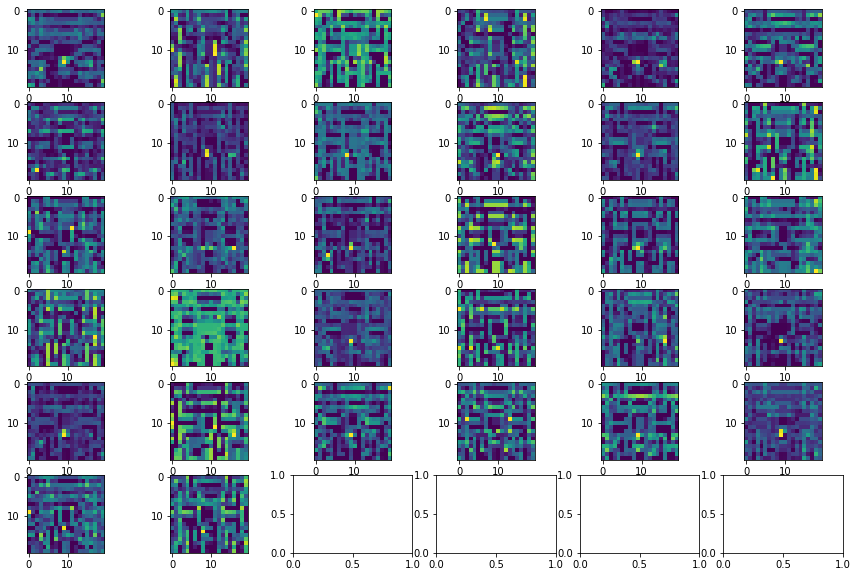

In [317]:
kernel_show(kernel_list=layer2_result[0], length=len(layer2_result[0]), row=6)

### Custom Layer

In [152]:
test_layer3 = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=16,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(16, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16,
        out_channels=32,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(32, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32,
        out_channels=64,
        kernel_size=2,
        device='cpu'),
    nn.BatchNorm2d(64, device='cpu'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
)

In [153]:
layer3_result = test_layer3(rgb_state)
layer3_result.shape

torch.Size([1, 64, 16, 16])

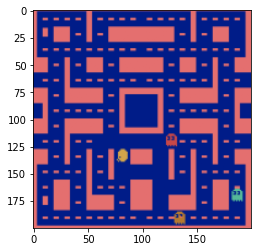

In [154]:
show_rgb_image(test_state)

In [155]:
len(layer3_result.view(-1))

16384

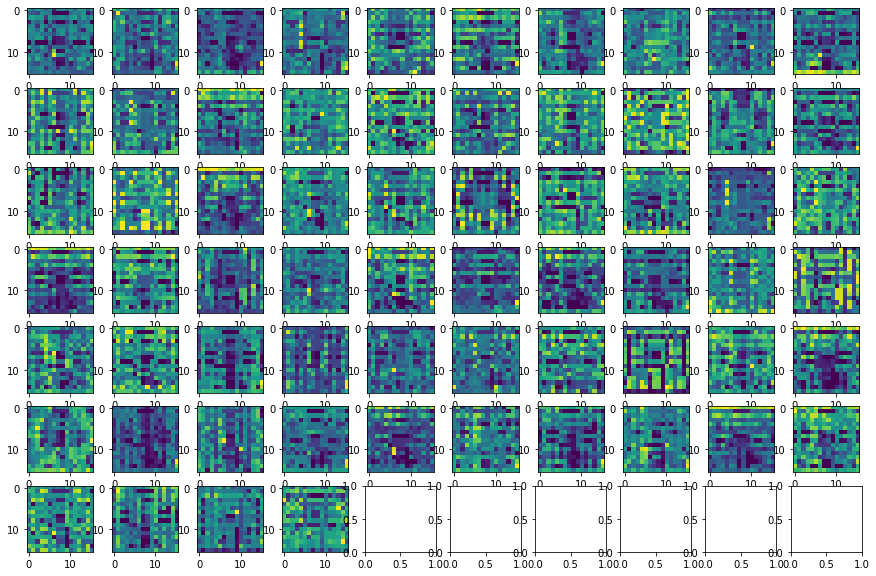

In [156]:
kernel_show(kernel_list=layer3_result[0], length=len(layer3_result[0]), row=10)